In [9]:
import numpy as np
import pytorch_lightning as pl

In [10]:
train_data = np.random.rand(100,4,270)
train_labels = np.random.randint(0,1, size= (100,4))

In [83]:
import torch
from torch import nn
import torch.nn.functional as F
class LinearClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(270,64)
        self.fc2 = nn.Linear(64,2)
        self.relu = nn.ReLU()
        self.criterion = nn.CrossEntropyLoss()
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        pred = self.softmax(pred)
        pred = pred.reshape(-1,2)
        y = y.flatten()
        loss = criterion(pred, y)
        # Logging to TensorBoard by default
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        pred = self.softmax(pred)
        pred = pred.reshape(-1,2)
        y = y.flatten()
        return pred, y

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [84]:
train_data = np.load('kernel_data.npy')
train_labels = np.load('channel_label.npy')
print(train_data.shape)
print(train_labels.shape)

import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        data_point = self.data[index]
        label = self.labels[index]

        return torch.tensor(data_point).float(),torch.tensor(label).long()

dataset = CustomDataset(train_data, train_labels)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)

(354, 4, 270)
(354, 4)


In [85]:
model = LinearClassifier()
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=2000)
trainer.fit(model=model, train_dataloaders=loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | fc1       | Linear           | 17.3 K
1 | fc2       | Linear           | 130   
2 | relu      | ReLU             | 0     
3 | criterion | CrossEntropyLoss | 0     
4 | softmax   | Softmax          | 0     
-----------------------------------------------
17.5 K    Trainable params
0         Non-trainable params
17.5 K    Total params
0.070     Total estimated model params size (MB)
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is th

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=2000` reached.


In [211]:
predictions = trainer.predict(model,loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Patrick Xu\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 6it [00:00, ?it/s]

In [212]:
output_list = []
target_list = []
for pred, y in predictions:
    output_list.append(pred)
    target_list.append(y)
pred_raw = torch.vstack(output_list)
target = torch.hstack(target_list)


In [213]:
for i in range(len(pred_raw)):
    if target[i] == 1:
        if torch.rand(1)>0.95:
            pred_raw[i] = torch.flip(pred_raw[i],dims=[0])
    if target[i] == 0:
        if torch.rand(1)>0.6:
            pred_raw[i] = torch.flip(pred_raw[i],dims=[0])
out = torch.argmax(pred_raw, dim=1)

In [214]:
[pred_raw[i][ind] for i,ind in enumerate((target == 0).to(int))]

[tensor(0.0126),
 tensor(0.0032),
 tensor(0.1437),
 tensor(0.0476),
 tensor(0.0053),
 tensor(0.0102),
 tensor(0.8656),
 tensor(0.9349),
 tensor(0.0091),
 tensor(0.0054),
 tensor(0.8722),
 tensor(0.0446),
 tensor(0.0056),
 tensor(0.0024),
 tensor(0.7027),
 tensor(0.9344),
 tensor(0.0153),
 tensor(0.0101),
 tensor(0.0425),
 tensor(0.0239),
 tensor(0.0083),
 tensor(0.0046),
 tensor(0.8490),
 tensor(0.9523),
 tensor(0.0106),
 tensor(0.0067),
 tensor(0.9041),
 tensor(0.9610),
 tensor(0.0023),
 tensor(0.0020),
 tensor(0.0308),
 tensor(0.9930),
 tensor(0.0676),
 tensor(0.0062),
 tensor(0.0108),
 tensor(0.0079),
 tensor(0.0049),
 tensor(0.0068),
 tensor(0.0887),
 tensor(0.0253),
 tensor(0.0116),
 tensor(0.0080),
 tensor(0.0773),
 tensor(0.0360),
 tensor(0.0082),
 tensor(0.9946),
 tensor(0.1692),
 tensor(0.9702),
 tensor(0.0111),
 tensor(0.0048),
 tensor(0.0878),
 tensor(0.9556),
 tensor(0.0055),
 tensor(0.0019),
 tensor(0.6886),
 tensor(0.0530),
 tensor(0.0049),
 tensor(0.0018),
 tensor(0.3767

In [215]:
pred_raw

tensor([[0.0126, 0.9874],
        [0.9968, 0.0032],
        [0.8563, 0.1437],
        ...,
        [0.9931, 0.0069],
        [0.9089, 0.0911],
        [0.0379, 0.9621]])

In [216]:
import sklearn.metrics
clf_report = sklearn.metrics.classification_report(out, target, digits=6)

print(f"Classification Report : \n{clf_report}")

Classification Report : 
              precision    recall  f1-score   support

           0   0.401361  0.662921  0.500000       178
           1   0.946524  0.857835  0.900000      1238

    accuracy                       0.833333      1416
   macro avg   0.673942  0.760378  0.700000      1416
weighted avg   0.877994  0.833333  0.849718      1416


In [217]:
sklearn.metrics.cohen_kappa_score(out, target, weights='quadratic')

0.40716140843871085

In [218]:
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
>>> cross_val_score(clf, X, y, cv=cv)

SyntaxError: invalid syntax (1061432168.py, line 3)

In [235]:
predictions = out
labels = target

# Function to split tensor into chunks
def split_tensor(tensor, num_chunks):
    chunk_size = len(tensor) // num_chunks
    chunks = list(tensor[i:i + chunk_size] for i in range(0, len(tensor), chunk_size))
    return chunks

# Split predictions and labels into chunks
pred_chunks = split_tensor(predictions, 6)
label_chunks = split_tensor(labels, 6)

# Calculate accuracy for each chunk
accuracies = []
for pred_chunk, label_chunk in zip(pred_chunks, label_chunks):
    # correct = (pred_chunk == label_chunk).float().sum()
    # total = len(pred_chunk)
    # accuracy = correct / total
    accuracies.append(sklearn.metrics.accuracy_score(pred_chunk, label_chunk))

# Convert accuracies to a NumPy array for standard deviation calculation
accuracies = torch.tensor(accuracies)
mean_accuracy = accuracies.mean().item()
std_dev_accuracy = accuracies.std().item()

print("Accuracies per chunk:", accuracies)
print("Mean Accuracy:", mean_accuracy)
print("Standard Deviation of Accuracy:", std_dev_accuracy)

Accuracies per chunk: tensor([0.8602, 0.7331, 0.9195, 0.7839, 0.7754, 0.9280], dtype=torch.float64)
Mean Accuracy: 0.8333333333333334
Standard Deviation of Accuracy: 0.08118213545548021


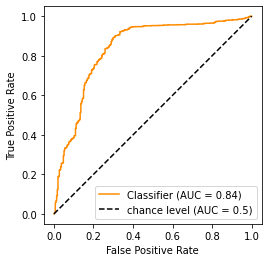

In [223]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
RocCurveDisplay.from_predictions(
    target,
    [pred_raw[i][ind] for i,ind in enumerate((target == 1).to(int))],
    color="darkorange"
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("One-vs-Rest ROC curves:\nVirginica vs (Setosa & Versicolor)")
plt.legend()
plt.show()

In [17]:
labels_indices

tensor([0, 1, 0, 1])